In [32]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
import pickle

sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')
import numpy as np
import networkx as nx

from src.stats import Stats
from src.models.Frobenius import Frobenius
from src.models.Procustes import Procustes
from src.models.DeltaCon import DeltaConWrapper
from src.models.WL import WL
from src.models.Spectrum import Spectrum

import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Defining the distances
distance_frobenius = Frobenius().forward
distance_procrustes_LE = Procustes().forward
DeltaConDistance = DeltaConWrapper().forward
WL_distance = WL(n_iter=5).forward
distance_eigen = lambda x,y: np.sqrt((Spectrum().forward(x) - Spectrum().forward(y))**2)

# Experiments 1: Random Graphs

In [61]:
n_nodes = 100 # number of nodes
p_values = np.linspace(0.01, 0.99, 11)  # different probability values
n_experiments = 10 # number of times to repeat each comparison

# n_nodes = 10
# p_values = np.linspace(0.01, 0.99, 3)
# n_experiments = 2

# Initialize results dictionary
results = {
    'Frobenius': [],
    'Procrustes': [],
    'DeltaCon': [],
    'WL': [],
    'Eigen': [],
    'p_values': [],
}

In [62]:
# Initialize empty lists to store results
data = []

for p1 in p_values:
    print(f'p = {p1}')
    for j in range(n_experiments):
        print(f'Experiment {j}')
        # Generate two random graphs with same probability
        G1 = nx.erdos_renyi_graph(n_nodes, p1)
        G2 = nx.erdos_renyi_graph(n_nodes, p1)
        
        # Convert to adjacency matrices
        A1 = nx.to_numpy_array(G1)
        A2 = nx.to_numpy_array(G2)
        
        # Convert to torch tensors for Procrustes
        A1_torch = torch.from_numpy(A1).float()
        A2_torch = torch.from_numpy(A2).float()
        
        # Calculate distances
        frob_dist = distance_frobenius(A1, A2)
        proc_dist = distance_procrustes_LE(A1_torch, A2_torch, k=10)
        delta_dist = DeltaConDistance(nx.from_numpy_array(A1), nx.from_numpy_array(A2))
        wl_dist = WL_distance(A1, A2)
        eigen_dist = distance_eigen(A1, A2)
        
        # Store results as a dictionary
        result_dict = {
            'p_value': p1,
            'experiment': j,
            'Frobenius': frob_dist,
            'Procrustes': proc_dist, 
            'DeltaCon': delta_dist,
            'WL': wl_dist,
            'Eigen': eigen_dist
        }
        data.append(result_dict)

# Convert to DataFrame
results_df = pd.DataFrame(data)
results_df.to_parquet(f'results_n_{n_nodes}.parquet')

p = 0.01
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.108
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.20600000000000002
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.30400000000000005
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.402
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.5
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
p = 0.5980000000000001
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experime

In [66]:
df = pd.read_parquet(f'results_n_{n_nodes}.parquet')
df.head()

,p_value,experiment,Frobenius,Procrustes,DeltaCon,WL,Eigen
0,0.01,0,14.560220,0.954260,6.361980,0.509113,0.937568
1,0.01,1,14.491377,0.956760,7.065877,0.505839,0.049629
2,0.01,2,14.000000,0.905499,6.835156,0.507244,0.012316
3,0.01,3,15.297059,0.935169,7.074715,0.504928,0.307076
4,0.01,4,13.784049,0.900838,7.150818,0.505815,0.004981


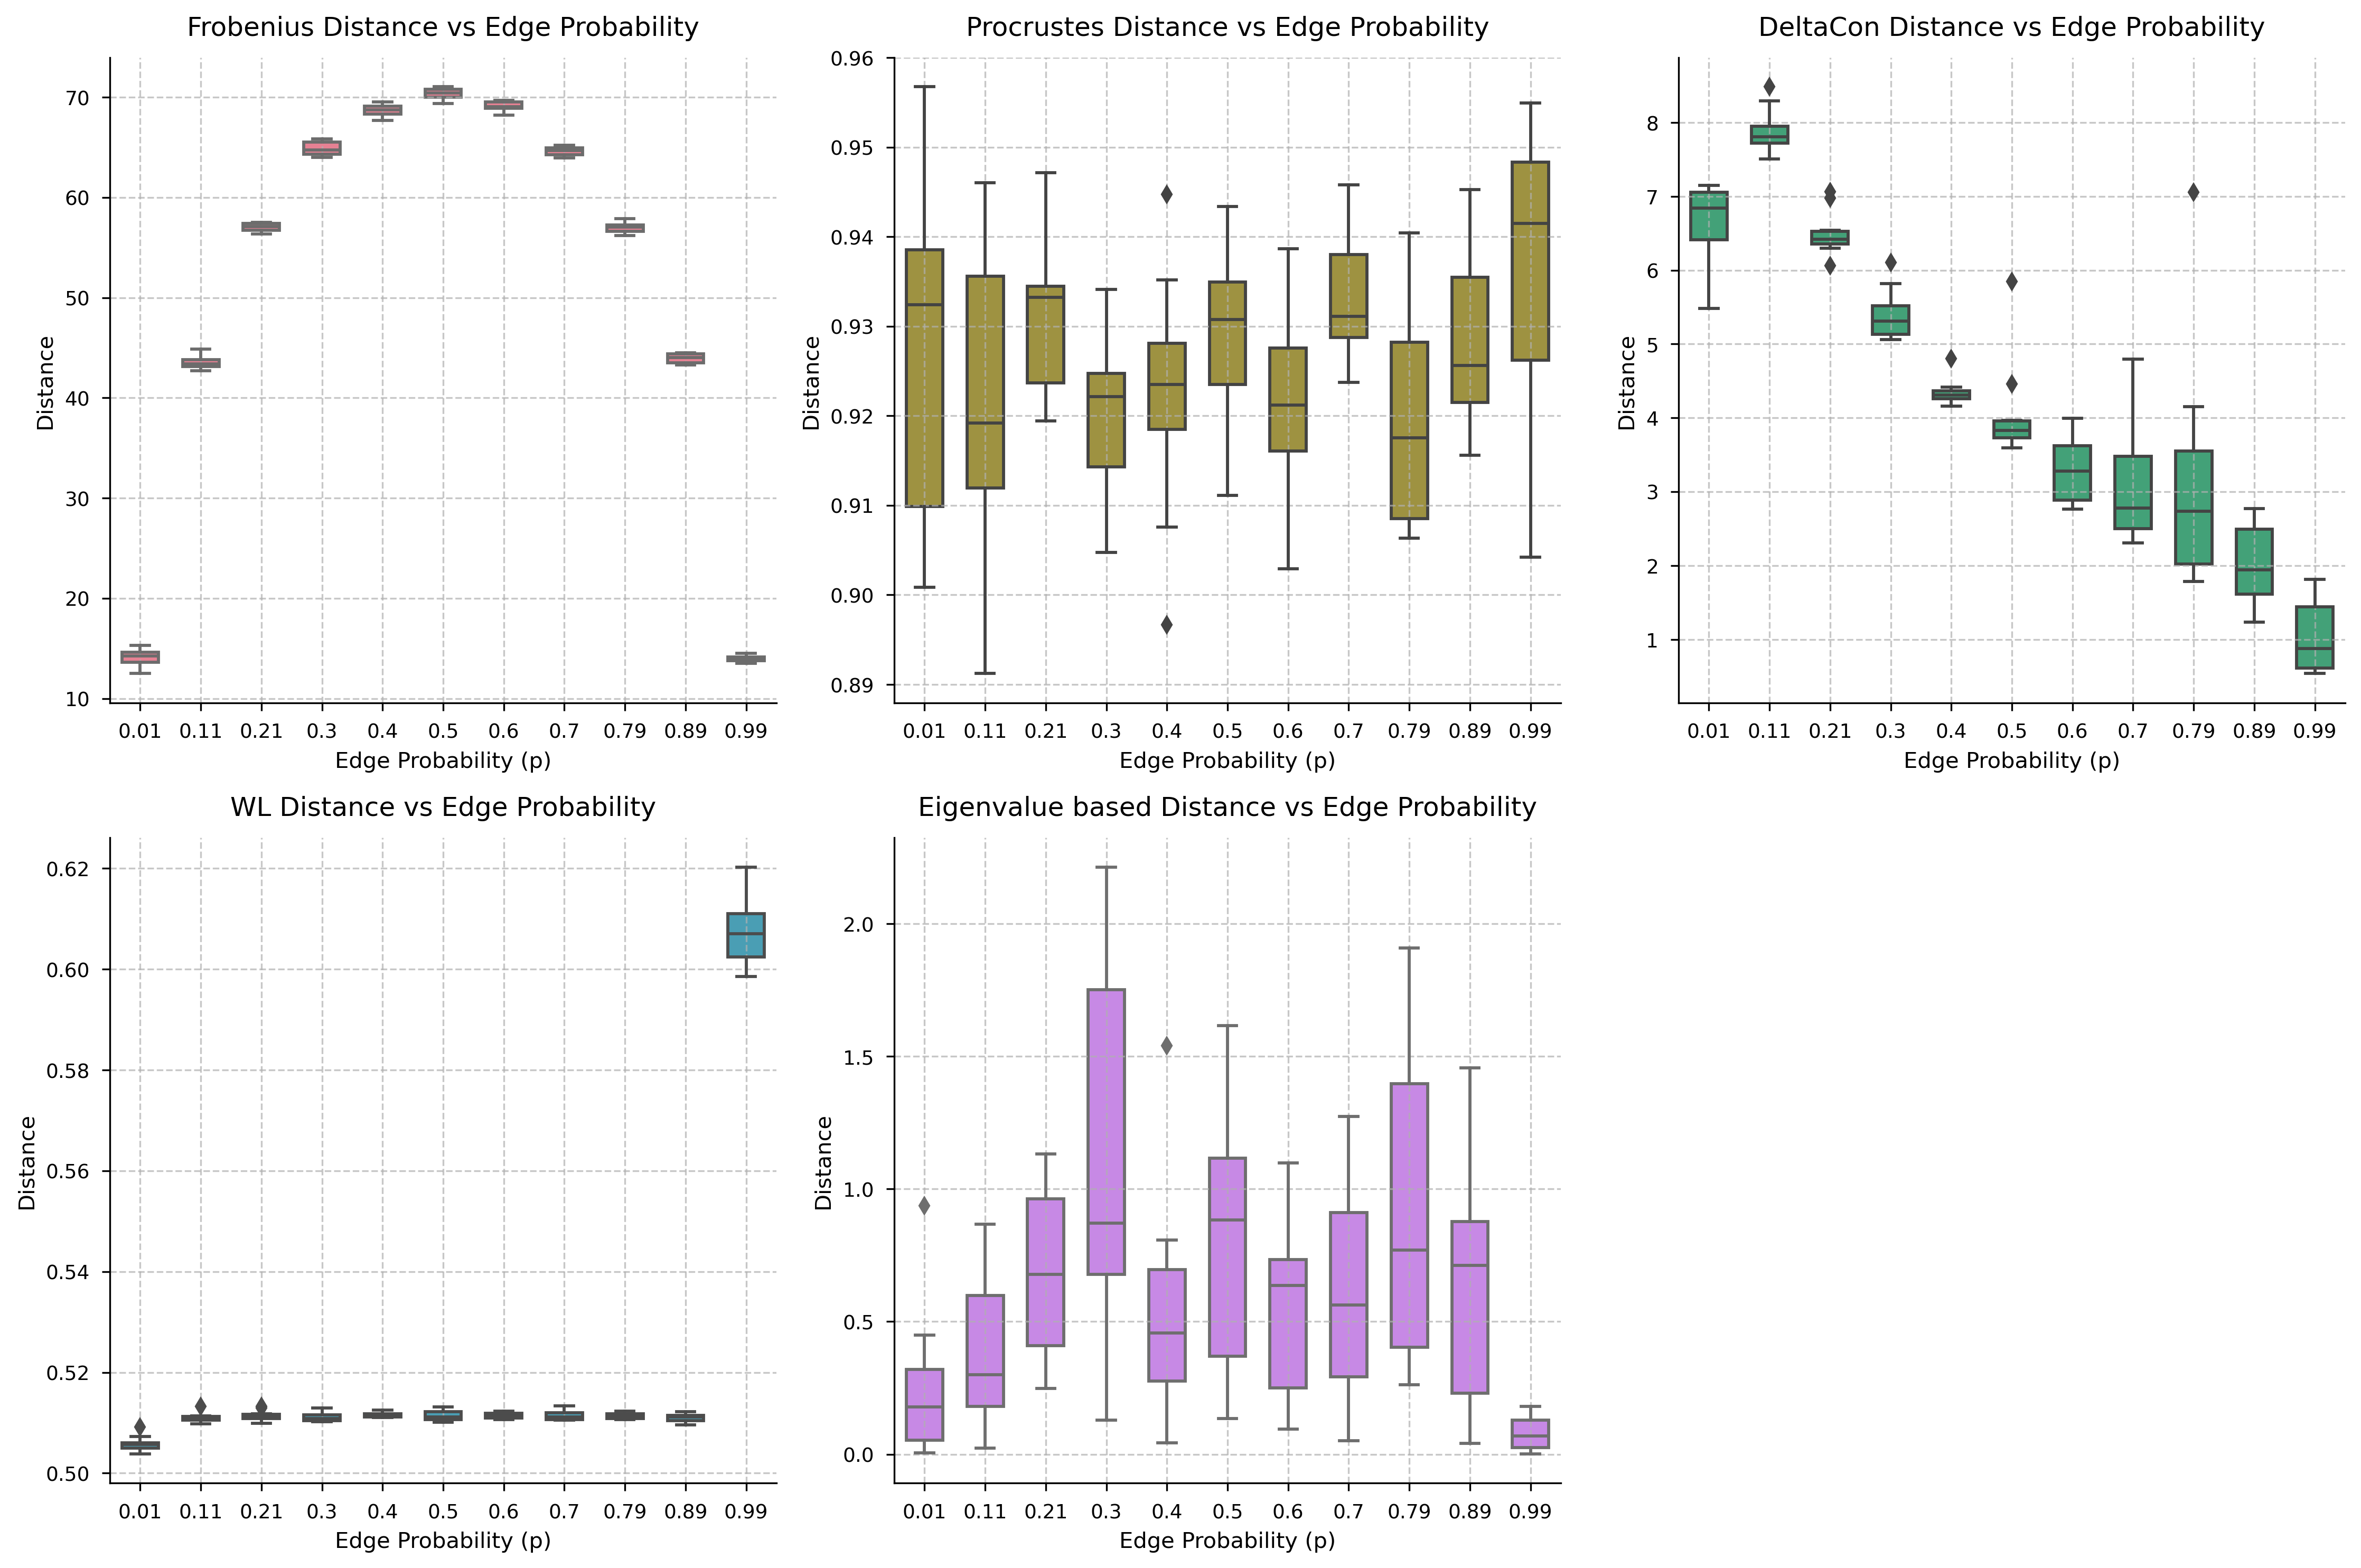

In [68]:
df = pd.read_parquet(f'results_n_{n_nodes}.parquet')
df['p_value'] = df['p_value'].round(2)

plt.style.use('seaborn-v0_8-paper')  # for older seaborn style
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
axes = axes.ravel()
metrics = ['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen']
colors = sns.color_palette("husl", len(metrics))

for i, metric in enumerate(metrics):
    sns.boxplot(x='p_value', y=metric, data=df, ax=axes[i], color=colors[i], width=0.6)
    
    if metric == 'Eigen':
        axes[i].set_title(f'Eigenvalue based Distance vs Edge Probability', fontsize=12, pad=10)
    else:
        axes[i].set_title(f'{metric} Distance vs Edge Probability', fontsize=12, pad=10)

    axes[i].set_xlabel('Edge Probability (p)', fontsize=10)
    axes[i].set_ylabel('Distance', fontsize=10)
    axes[i].tick_params(labelsize=9)

    # Format x-axis to show 2 decimal places
    #axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Remove the empty sixth subplot
axes[-1].remove()

plt.tight_layout()
plt.show()


In [69]:
# # Calculate correlations between distances
# distance_matrix = np.array([
#     results['Frobenius'],
#     results['Procrustes'],
#     results['DeltaCon'],
#     results['WL'],
#     results['Eigen'],
# ]).T

# correlation_matrix = np.corrcoef(distance_matrix.T)
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix,
#             annot=True,
#             fmt='.2f',
#             xticklabels=['Frobenius', 'Procrustes', 'DeltaCon', 'WL'],
#             yticklabels=['Frobenius', 'Procrustes', 'DeltaCon', 'WL'])
# plt.title('Correlation between Distance Measures')
# plt.show()

# Experiments 2: Same Family

In [75]:
def calculate_distances(G1, G2):
    """Calculate all distances between two graphs"""
    # Convert to adjacency matrices
    A1 = nx.to_numpy_array(G1)
    A2 = nx.to_numpy_array(G2)
    
    # Convert to torch tensors for Procrustes
    A1_torch = torch.from_numpy(A1).float()
    A2_torch = torch.from_numpy(A2).float()
    
    return {
        'Frobenius': distance_frobenius(A1, A2),
        'Procrustes': distance_procrustes_LE(A1_torch, A2_torch, k=10),
        'DeltaCon': DeltaConDistance(nx.from_numpy_array(A1), nx.from_numpy_array(A2)),
        'WL': WL_distance(A1, A2),
        'Eigen': distance_eigen(A1, A2),
    }

In [80]:
# Initialize results
results = {
    'Distance': [],
    'Value': [],
    'Comparison': [],
    'Model': []
}

# Define graph models and their parameters
graph_models = {
    'Erdos-Renyi': {
        'similar': [(0.3, 0.31)],  # (p1, p2) pairs
        'dissimilar': [(0.2, 0.8)],
        'generator': lambda p: nx.erdos_renyi_graph(n_nodes, p)
    },
    'Watts-Strogatz': {
        'similar': [(0.1, 0.12)],  # (beta1, beta2) pairs with k=4
        'dissimilar': [(0.1, 0.9)],
        'generator': lambda beta: nx.watts_strogatz_graph(n_nodes, 4, beta)
    },
    'Barabasi-Albert': {
        'similar': [(3, 4)],  # (m1, m2) pairs
        'dissimilar': [(2, 10)],
        'generator': lambda m: nx.barabasi_albert_graph(n_nodes, m)
    },
    'Stochastic-Block': {
        'similar': [(0.3, 0.1, 0.31, 0.11)],  # (p_in1, p_out1, p_in2, p_out2)
        'dissimilar': [(0.3, 0.1, 0.8, 0.6)],
        'generator': lambda p_in, p_out: nx.stochastic_block_model(
            sizes=[n_nodes//2, n_nodes//2],
            p=[[p_in, p_out], [p_out, p_in]]
        )
    }
}


n_nodes = 100
n_experiments = 10

In [81]:
# Initialize empty list to store results
data = []

# Run experiments
for model_name, model_info in graph_models.items():
    print(f"Processing {model_name}...")
    
    # Similar graphs
    for params in model_info['similar']:
        for exp in range(n_experiments):
            print(f'Experiment {exp}')
            if model_name == 'Stochastic-Block':
                G1 = model_info['generator'](params[0], params[1])
                G2 = model_info['generator'](params[2], params[3])
            else:
                G1 = model_info['generator'](params[0])
                G2 = model_info['generator'](params[1])
            
            distances = calculate_distances(G1, G2)
            result_dict = {
                'model': model_name,
                'experiment': exp,
                'comparison': 'Similar',
                **distances
            }
            data.append(result_dict)
    
    # Dissimilar graphs
    for params in model_info['dissimilar']:
        for exp in range(n_experiments):
            print(f'Experiment {exp}')
            if model_name == 'Stochastic-Block':
                G1 = model_info['generator'](params[0], params[1])
                G2 = model_info['generator'](params[2], params[3])
            else:
                G1 = model_info['generator'](params[0])
                G2 = model_info['generator'](params[1])
            
            distances = calculate_distances(G1, G2)
            result_dict = {
                'model': model_name,
                'experiment': exp,
                'comparison': 'Dissimilar',
                **distances
            }
            data.append(result_dict)

# Convert to DataFrame and save
results_df = pd.DataFrame(data)
results_df.to_parquet('results_same_family.parquet')


Processing Erdos-Renyi...
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Processing Watts-Strogatz...
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Processing Barabasi-Albert...
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9
Processing Stochastic-Block...
Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7


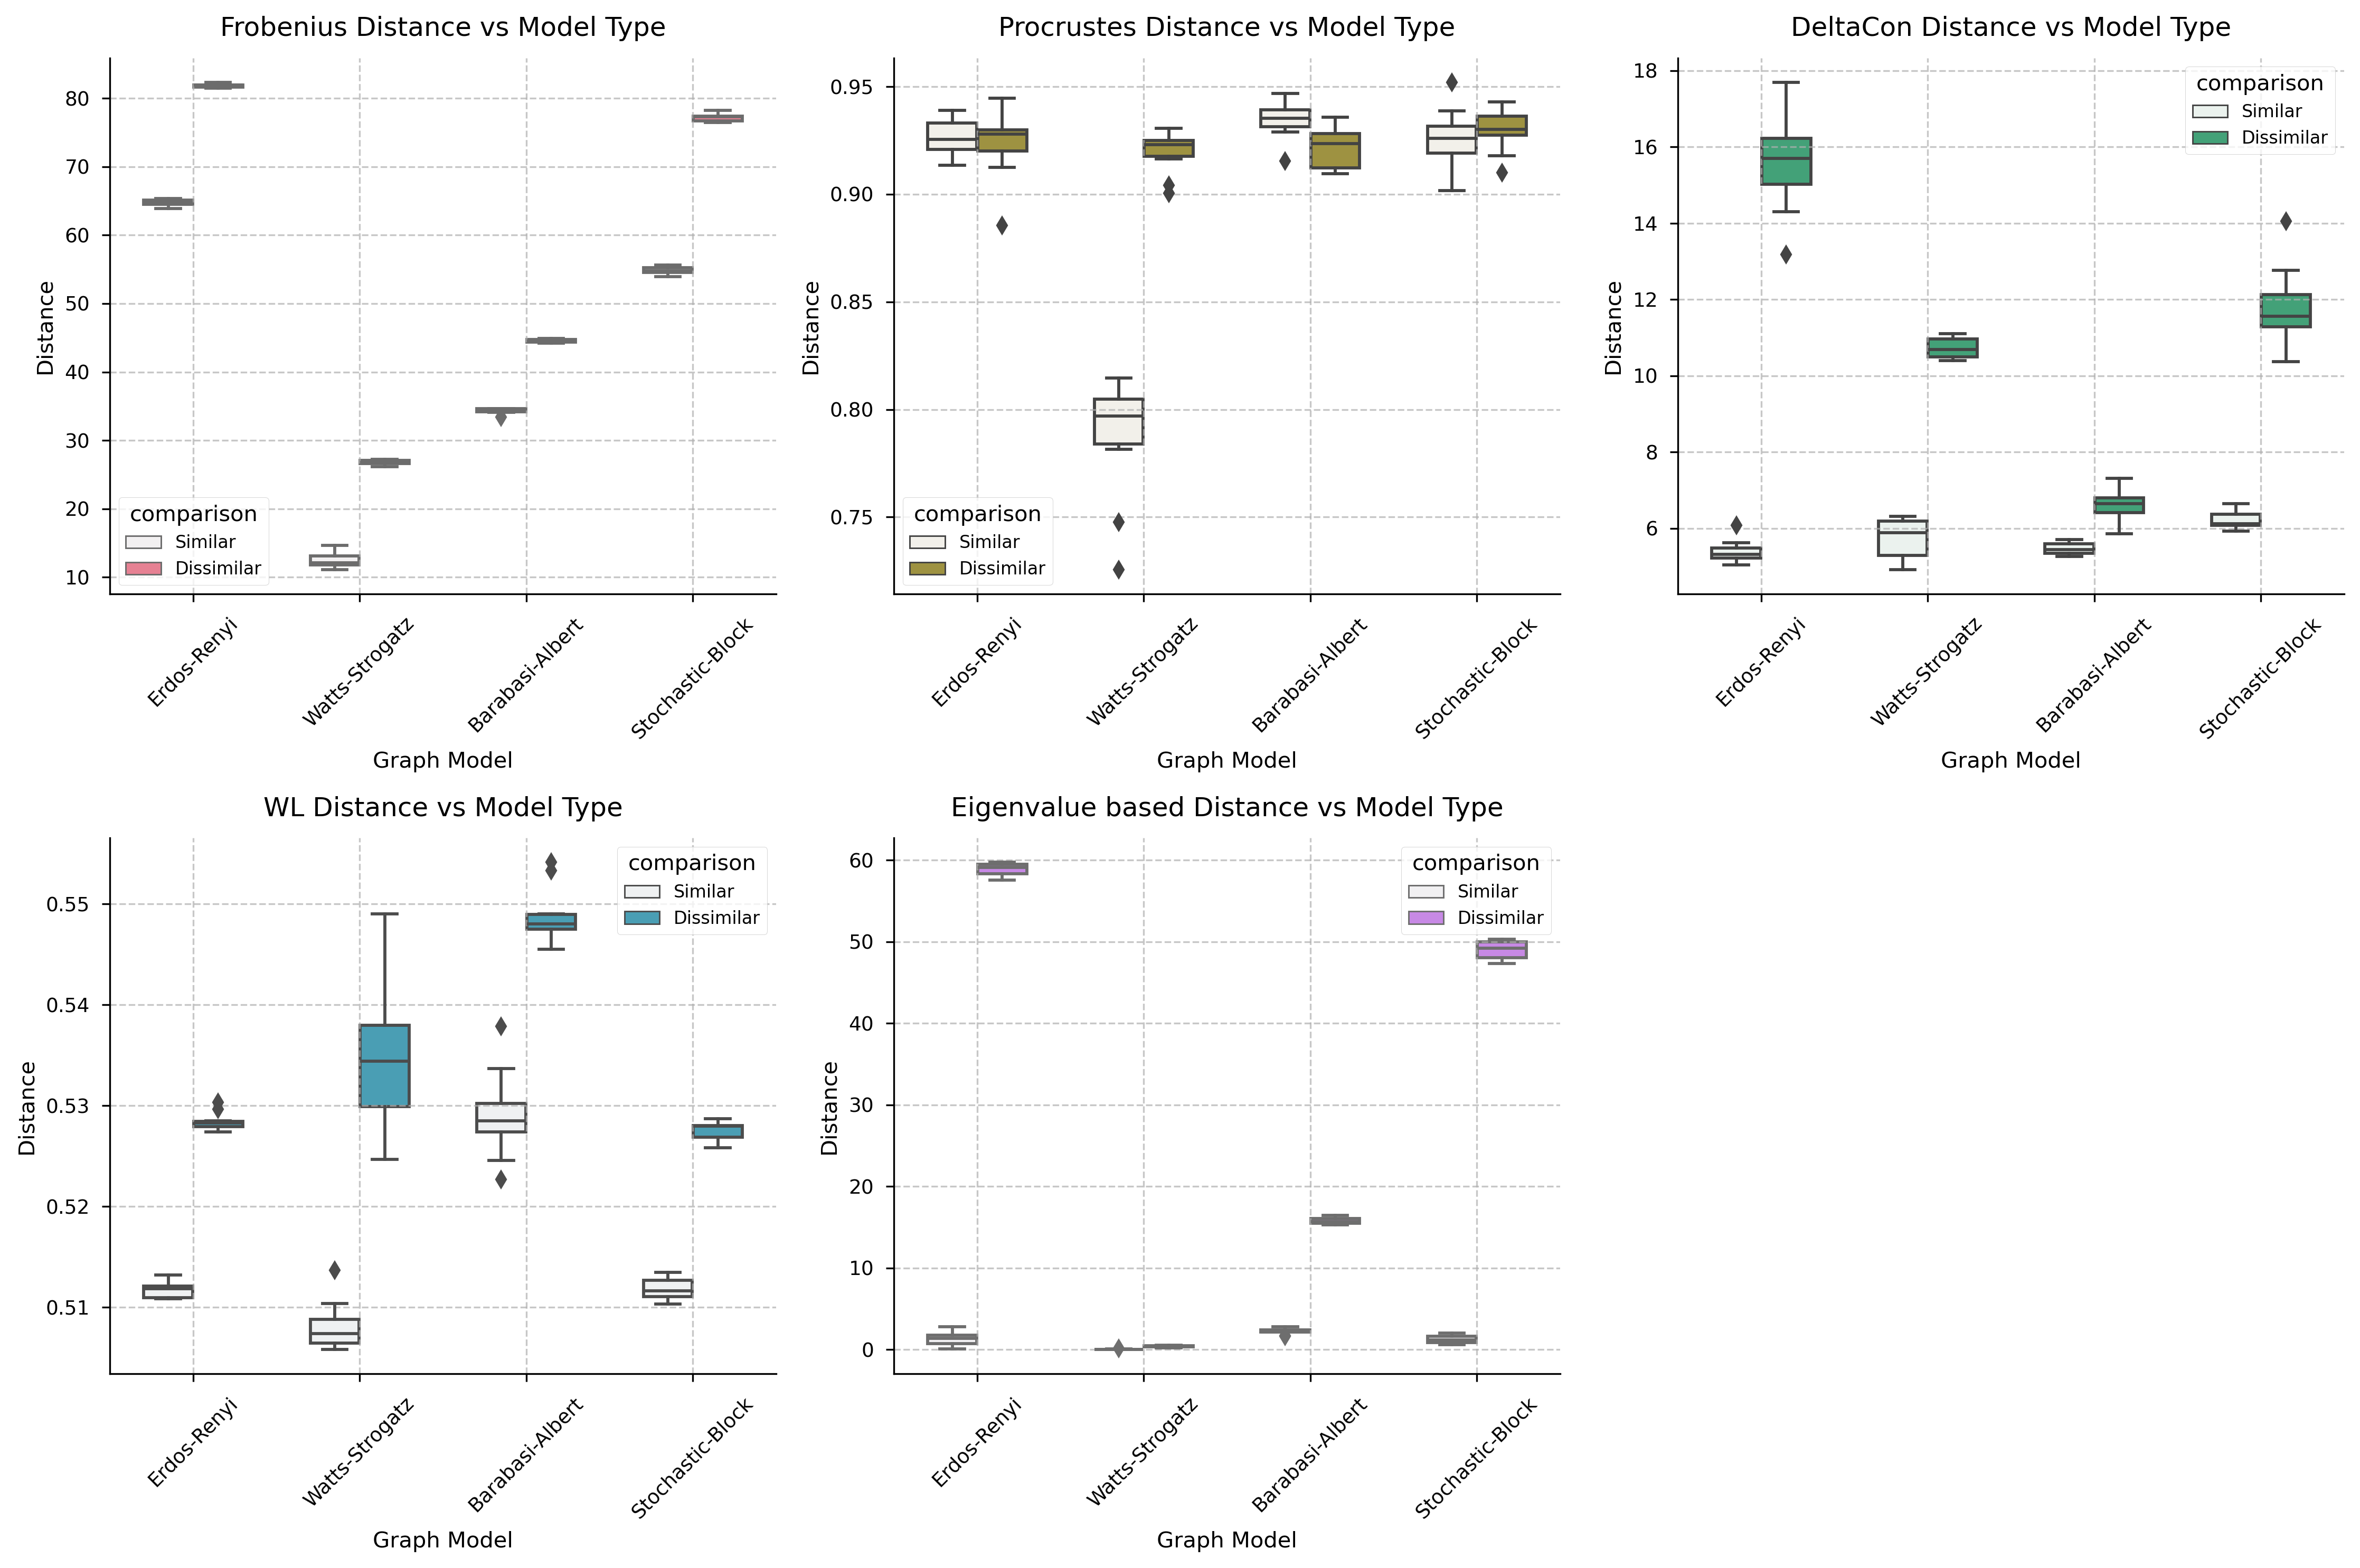

In [86]:
# Read the parquet file
df = pd.read_parquet('results_same_family.parquet')

plt.style.use('seaborn-v0_8-paper')  # for older seaborn style
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
axes = axes.ravel()
metrics = ['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen']
colors = sns.color_palette("husl", len(metrics))

for i, metric in enumerate(metrics):
    sns.boxplot(x='model', y=metric, hue='comparison', data=df, ax=axes[i], color=colors[i], width=0.6)
    
    if metric == 'Eigen':
        axes[i].set_title(f'Eigenvalue based Distance vs Model Type', fontsize=12, pad=10)
    else:
        axes[i].set_title(f'{metric} Distance vs Model Type', fontsize=12, pad=10)

    axes[i].set_xlabel('Graph Model', fontsize=10)
    axes[i].set_ylabel('Distance', fontsize=10)
    axes[i].tick_params(labelsize=9)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Calculate and annotate mean differences for each model
    # for model in df['model'].unique():
    #     similar = df[(df['model'] == model) & (df['comparison'] == 'Similar')][metric].mean()
    #     dissimilar = df[(df['model'] == model) & (df['comparison'] == 'Dissimilar')][metric].mean()
    #     diff = dissimilar - similar
        
    #     # Get x-coordinate for the model
    #     x_pos = list(df['model'].unique()).index(model)
        
    #     # Add annotation arrow and text
    #     y_pos = (similar + dissimilar) / 2
    #     axes[i].annotate(f'Δ={diff:.2f}', 
    #                     xy=(x_pos, y_pos),
    #                     xytext=(x_pos + 0.3, y_pos),
    #                     arrowprops=dict(arrowstyle='->'),
    #                     fontsize=8)

# Remove the empty sixth subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

# Experiments 3: Different Family


In [ ]:
# Define graph models and their parameters for different families
graph_models = {
    'ER-SBM': {
        'similar': [(0.3, 0.3, 0.1)],  # (p_er, p_in, p_out)
        'dissimilar': [(0.3, 0.8, 0.1)],
        'generator1': lambda p: nx.erdos_renyi_graph(n_nodes, p),
        'generator2': lambda p_in, p_out: nx.stochastic_block_model(
            sizes=[n_nodes//2, n_nodes//2],
            p=[[p_in, p_out], [p_out, p_in]]
        )
    },
    'WS-ER': {
        'similar': [(4, 0.1, 0.3)],  # (k, p_ws, p_er)
        'dissimilar': [(4, 0.1, 0.8)],
        'generator1': lambda k, p: nx.watts_strogatz_graph(n_nodes, k, p),
        'generator2': lambda p: nx.erdos_renyi_graph(n_nodes, p)
    },
    'BA-SBM': {
        'similar': [(3, 0.3, 0.1)],  # (m, p_in, p_out)
        'dissimilar': [(3, 0.8, 0.1)],
        'generator1': lambda m: nx.barabasi_albert_graph(n_nodes, m),
        'generator2': lambda p_in, p_out: nx.stochastic_block_model(
            sizes=[n_nodes//2, n_nodes//2],
            p=[[p_in, p_out], [p_out, p_in]]
        )
    },
    'BA-WS': {
        'similar': [(3, 4, 0.1)],  # (m, k, p)
        'dissimilar': [(10, 4, 0.9)],
        'generator1': lambda m: nx.barabasi_albert_graph(n_nodes, m),
        'generator2': lambda k, p: nx.watts_strogatz_graph(n_nodes, k, p)
    },
    'ER-BA': {
        'similar': [(0.3, 3)],  # (p, m)
        'dissimilar': [(0.8, 10)],
        'generator1': lambda p: nx.erdos_renyi_graph(n_nodes, p),
        'generator2': lambda m: nx.barabasi_albert_graph(n_nodes, m)
    },
    'WS-SBM': {
        'similar': [(4, 0.1, 0.3, 0.1)],  # (k, p_ws, p_in, p_out)
        'dissimilar': [(4, 0.1, 0.8, 0.6)],
        'generator1': lambda k, p: nx.watts_strogatz_graph(n_nodes, k, p),
        'generator2': lambda p_in, p_out: nx.stochastic_block_model(
            sizes=[n_nodes//2, n_nodes//2],
            p=[[p_in, p_out], [p_out, p_in]]
        )
    }
}

n_nodes = 100
n_experiments = 20


In [ ]:
data = []

# Run experiments
for model_pair, model_info in graph_models.items():
    print(f"Processing {model_pair}...")
    
    # Similar graphs
    for params in model_info['similar']:
        for exp in range(n_experiments):
            print(f'Experiment {exp}')
            
            # Generate graphs based on model pair
            if model_pair == 'ER-SBM':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1], params[2])
            elif model_pair == 'WS-ER':
                G1 = model_info['generator1'](params[0], params[1])
                G2 = model_info['generator2'](params[2])
            elif model_pair == 'BA-SBM':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1], params[2])
            elif model_pair == 'BA-WS':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1], params[2])
            elif model_pair == 'ER-BA':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1])
            elif model_pair == 'WS-SBM':
                G1 = model_info['generator1'](params[0], params[1])
                G2 = model_info['generator2'](params[2], params[3])
            
            distances = calculate_distances(G1, G2)
            result_dict = {
                'model': model_pair,
                'experiment': exp,
                'comparison': 'Similar',
                **distances
            }
            data.append(result_dict)
    
    # Dissimilar graphs
    for params in model_info['dissimilar']:
        for exp in range(n_experiments):
            print(f'Experiment {exp}')
            
            # Generate graphs based on model pair (same logic as above)
            if model_pair == 'ER-SBM':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1], params[2])
            elif model_pair == 'WS-ER':
                G1 = model_info['generator1'](params[0], params[1])
                G2 = model_info['generator2'](params[2])
            elif model_pair == 'BA-SBM':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1], params[2])
            elif model_pair == 'BA-WS':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1], params[2])
            elif model_pair == 'ER-BA':
                G1 = model_info['generator1'](params[0])
                G2 = model_info['generator2'](params[1])
            elif model_pair == 'WS-SBM':
                G1 = model_info['generator1'](params[0], params[1])
                G2 = model_info['generator2'](params[2], params[3])
            
            distances = calculate_distances(G1, G2)
            result_dict = {
                'model': model_pair,
                'experiment': exp,
                'comparison': 'Dissimilar',
                **distances
            }
            data.append(result_dict)

# Convert to DataFrame and save
results_df = pd.DataFrame(data)
results_df.to_parquet('results_diff_family.parquet')


In [ ]:
# Create plots with consistent styling
plt.style.use('seaborn-v0_8-paper')
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
axes = axes.ravel()
metrics = ['Frobenius', 'Procrustes', 'DeltaCon', 'WL', 'Eigen']
colors = sns.color_palette("husl", len(metrics))

for i, metric in enumerate(metrics):
    sns.boxplot(x='model', y=metric, hue='comparison', data=results_df, 
                ax=axes[i], color=colors[i], width=0.6)
    
    if metric == 'Eigen':
        axes[i].set_title(f'Eigenvalue based Distance vs Model Pairs', fontsize=12, pad=10)
    else:
        axes[i].set_title(f'{metric} Distance vs Model Pairs', fontsize=12, pad=10)

    axes[i].set_xlabel('Graph Model Pairs', fontsize=10)
    axes[i].set_ylabel('Distance', fontsize=10)
    axes[i].tick_params(labelsize=9)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Remove the empty sixth subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

# Create heatmap
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    pivot_data = results_df.pivot_table(
        values=metric,
        index='model',
        columns='comparison',
        aggfunc='mean'
    )
    sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title(f'{metric} Distance')

plt.tight_layout()
plt.show()